In [49]:
# Bloc non affiché

import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, matthews_corrcoef, make_scorer

from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier


from sklearn.ensemble import RandomForestClassifier




def result_model(model,X,Y, mat = True) :
    Y_model =model.predict(X)

    f1_scor = f1_score(Y,Y_model)
    print('Le f1 score vaut',f1_scor)
    
#     score = cross_val_score(model,X,Y,cv=5,scoring = make_scorer(f1_score))
#     print('F1 cross validé :', np.mean(score))
    
    if mat:
    # Matrice de confusion
        cm_model = confusion_matrix(Y, Y_model)
        plt.rcParams['figure.figsize'] = (5, 5)
        sns.heatmap(cm_model, annot = True)
        plt.title(str(model))
        plt.show()
    

# Modèle finale

## Téléchargement des données

In [22]:
train = pd.read_csv("https://www.data.mclavier.com/prj_datascience/train_v1.csv")

## Pre-processing

On sépare dans un premier temps les variables explicatives et la variable à expliquer.

In [23]:
X = train.drop(columns='Response')
Y = train['Response']

Le modèle final sera entrainé sur l'intégralité de la base que nous possédons. Mais actuellement, nous souhaitons mesure le caractère prédictif de nos données et donc pour éviter l'overfitting, nous séparons tout de même nos données.

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,train_size = 0.85)

## Modèle

Au final, deux modèles sont proches. Le Random Forest et le XGBoost.

### XGBoost

On utilise les paramètres déterminé dans le précédent notebook

In [68]:
 params_xg = {
    'objective': 'binary:logistic',
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': 0.9,
    'gamma': 0,
    'gpu_id': -1,
    'interaction_constraints': '',
    'learning_rate': 0.1,
    'max_delta_step': 0,
    'max_depth': 50,
    'min_child_weight': 5,
    'monotone_constraints': '()',
    'n_jobs': 8,
    'num_parallel_tree': 1,
    'predictor': 'auto',
    'random_state': 0,
    'reg_alpha': 1e-05,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'subsample': 0.7,
    'tree_method': 'exact',
    'validate_parameters': 1,
    'verbosity': None,
    'seed': 27,
    'nthread': 7,
    'use_label_encoder': False,
    'n_estimators': 1000
}

In [51]:
xgb0 = XGBClassifier(**params_xg)
rus = RandomUnderSampler(sampling_strategy = 0.85)
X_rus , Y_rus = rus.fit_resample(X_train ,Y_train)
xgb0 = xgb0.fit(X_rus, Y_rus)

[16:22:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Le f1 score vaut 0.5326086956521738


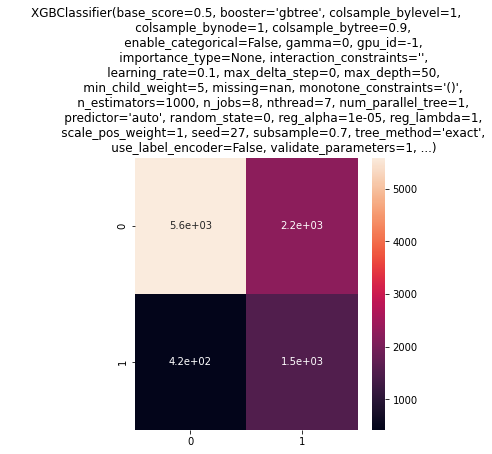

In [47]:
result_model(xgb0, X_test, Y_test, mat = True)

In [59]:
scores_xg = cross_val_score(xgb0, X_test, Y_test, cv=5, scoring='f1')
print("F1 moyen de %0.2f avec un écart type de %0.2f" % (scores_xg.mean(), scores_xg.std()))

[16:31:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:31:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [60]:
print("F1 moyen de %0.2f avec un écart type de %0.2f" % (scores_xg.mean(), scores_xg.std()))

F1 moyen de 0.39 avec un écart type de 0.02


### Random Forest

Finalement, nous avons peut-être été chanceux avec la méthode par tâtonnement car le random forest paraît très efficace avec des temps d'entrainement bien moindres.

In [55]:
params_rf = {
    'min_samples_split': 0.11959494750571721, 
    'min_samples_leaf' : 0.08048576405844253,
    'min_impurity_decrease' : 0.030792701550521537, 
    'n_estimators' : 88, 
    'class_weight' : 'balanced'
}

Entrainement.

In [56]:
rfc = RandomForestClassifier(**params_rf)
rfc.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced',
                       min_impurity_decrease=0.030792701550521537,
                       min_samples_leaf=0.08048576405844253,
                       min_samples_split=0.11959494750571721, n_estimators=88)

Résultat simple puis cross-validé.

Le f1 score vaut 0.5533742331288344


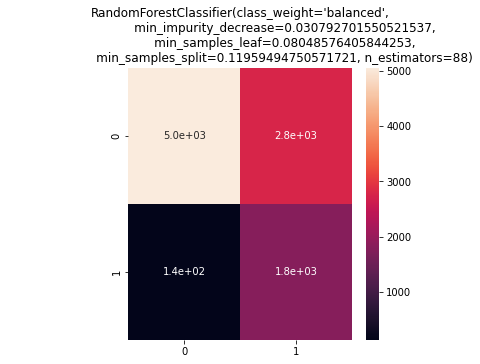

In [57]:
result_model(rfc, X_test, Y_test)

In [54]:
scores_rf = cross_val_score(rfc, X_test, Y_test, cv=5, scoring='f1')
print("F1 moyen de %0.2f avec un écart type de %0.2f" % (scores_rf.mean(), scores_rf.std()))

F1 moyen de 0.54 avec un écart type de 0.01


In [ ]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

feature_names = [i for i in X.columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize = (10, 5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Export des prédictions

Pour le rendu final, nous entrainons la base de données sur toute la bdd train.

**Traitement de la bdd test**

Nous appliquons le même traitement à la bdd test qu'à la bdd train.

In [62]:
test = pd.read_csv("https://www.data.mclavier.com/prj_datascience/brut_test.csv")
test.drop(columns='id', inplace = True)

dict_cat = {'No' : 0, 'Yes' : 1}
test.Vehicle_Damage.replace(dict_cat, inplace = True)

dict_cat = {'Male' : 0, 'Female' : 1}
test.replace(dict_cat, inplace = True)

dict_cat = {152 : 0, 26 : 1, 124 : 2}

def default_dict(x):
    if x in dict_cat:
        return dict_cat[x]
    else:
        return 3

new_damage = test.Policy_Sales_Channel.apply(lambda x : default_dict(x))
test['Policy_Sales_Channel'] = new_damage


dict_age = {'1-2 Year' : 1, '< 1 Year' : 0, '> 2 Years' : 2}
test.replace(dict_age, inplace = True)

X_to_predict = test

In [63]:
X_to_predict.head(3)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,49,1,18,0,1,1,38609,2,180
1,1,26,1,11,1,0,0,18452,0,105
2,1,80,1,28,0,2,1,30245,1,167


In [69]:
xgb_final = XGBClassifier(**params_xg)
xgb_final.fit(X, Y)

rfc_final = RandomForestClassifier(**params_rf)
rfc_final.fit(X, Y)

[16:35:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomForestClassifier(class_weight='balanced',
                       min_impurity_decrease=0.030792701550521537,
                       min_samples_leaf=0.08048576405844253,
                       min_samples_split=0.11959494750571721, n_estimators=88)

In [70]:
Y_predict = rfc_final.predict(X_to_predict)

In [77]:
np.mean(Y_predict)

0.5267132867132868

In [71]:
Y_predict_xg = xgb_final.predict(X_to_predict)

In [76]:
np.mean(Y_predict_xg)

0.17034965034965036

On l'exporte sous le même format que la base de donnée X.

In [66]:
Y_predict = pd.DataFrame(Y_predict)
Y_predict.rename(columns={0:'Response'}, inplace = True)
id_col = pd.read_csv("https://www.data.mclavier.com/prj_datascience/brut_test.csv", usecols=['id']).values
Y_predict['id'] = id_col
Y_predict = Y_predict[['id', 'Response']]

Y_predict.head()

,id,Response
0,1,1
1,2,0
2,3,1
3,4,1
4,5,0


In [82]:
Y_predict.to_csv("groupe_1_predictions.csv", index = False)

Vérification du fichier :

In [84]:
pd.read_csv('groupe_1_predictions.csv')

,id,Response
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0
...,...,...
7145,7146,0
7146,7147,0
7147,7148,0
7148,7149,0


## Conclusion

Vous pouvez télécharger le fichier [groupe_1_prediction.csv](https://www.data.mclavier.com/prj_datascience/groupe_1_predictions.csv) pour évaluer le modèle.

<br><br><br><br><br><br><br>